In [1]:
import numpy as np
import itertools as it
import scipy.ndimage.filters as fi
import matplotlib.pyplot as plt

import pdb

In [24]:
import numpy as np
from scipy.spatial import distance as D
import itertools as it
import types

METRICS = "braycurtis canberra chebyshev cityblock correlation cosine euclidean jensenshannon mahalanobis minkowski seuclidean sqeuclidean wminkowski".split(" ")

class GSOM():
    def __init__( self, n=100, dim=3, LR=.001, alfa=0.99, initial_size=(2, 2), max_size=(50, 50), SF=.5,
                  nbg="hat", lattice="rect" ):

        self.n_data = n 						# Number of samples
        self.dim = dim							# Number of features
        self.LR_i = LR
        self.lr = LR
        self.alfa = alfa

        self.initial_size = np.array(initial_size)			# Initial shape
        self.ms = np.array(max_size)						# Max shape of the map
        self.spread_factor = SF 							# Spread Factor
        self.GT = (-n)*np.math.log( SF )					# Growing Threshold
        self.offset = np.array(max_size)//2 				# Initial shape
        self.map = None
        self.mask = None
        self.boundary = None
        self.hit_map = None

        self.nbg = None
        self.nbg_algorithm = nbg
        # self.nbg_functions = { "rect":self.rect_nbg, "hexa":self.hexa_nbg }
        self.nbg_functions = Nbg_function()
        self.custom_metric = None

        self.error_map = None
        self.H_err = 0
        self.Q_e = 0
        self.inf_map = None
        self.completed_epochs = 0
        self.generate_map( )

    def generate_map( self ):
        self.map = np.random.rand( self.ms[0], self.ms[1], self.dim )
        self.mask = np.zeros( self.ms, dtype=np.bool )
        idx_i = self.offset+self.initial_size
        self.mask[ self.offset[0]:idx_i[0], self.offset[1]:idx_i[1] ] = True
        self.error_map = np.zeros( self.ms )
        self.boundary = np.zeros( self.ms, dtype=np.bool )
        self.boundary[ self.offset ] = True
        self.hit_map = np.zeros( self.ms, dtype=np.int )
        self.inf_map = np.full(  self.ms, np.inf )
        self.completed_epochs = 0
        return


    def apply_metric( self, vector ):
        values = D.cdist( vector.reshape(-1, self.dim), self.map[ self.mask ].reshape(-1, self.dim), self.custom_metric)
        return values

    def set_metric( self, metric ):
        self.custom_metric = metric
        if isinstance( metric, str):
            if not metric in METRICS:
                print(" Error! metric name must be in the scipy distance options(current default metric:euclidean)")
                print(" Available metric\n: {}".format( METRICS ))
                self.custom_metric = "euclidean"
                return

        if isinstance( metric, types.FunctionType ):
            self.custom_metric = metric
            print(" Working with ustom metric ")
        return


    def bmu( self, vector, return_second=False ):
        # values = self.apply_metric( vector )
        values = D.cdist( vector.reshape(-1, self.dim), self.map[ self.mask ].reshape(-1, self.dim), self.custom_metric )
        v_values = self.inf_map.copy()
#         pdb.set_trace()
        v_values[ self.mask ] = values.flatten() # reshape(-1, self.dim)
        # bmu = np.argmin(values)
        bmu = np.argmin( v_values )
        bmu = np.unravel_index( bmu, self.ms )
        if return_second:                    # For Topologic Error calculation
            # tmp = values[bmu[0],bmu[1]]
            # values[bmu[0],bmu[1]] = np.inf
            # bmu_2 = np.argmin( values )
            tmp = v_values[ bmu[0],bmu[1] ]
            v_values[bmu[0],bmu[1]] = np.inf
            bmu_2 = np.argmin( v_values )
            bmu_2 = np.unravel_index( bmu_2, self.ms )
            # return bmu, bmu_2, tmp, values[bmu_2]
        # return bmu, values[bmu[0],bmu[1]]
            return np.array(bmu), np.array(bmu_2), tmp, v_values[bmu_2[0], bmu_2[1]]
        return np.array(bmu), v_values[bmu[0], bmu[1]]
    
    def fit(self, data, n_epochs, initialize=False, rin=2, rend=1):		
        radiusin, radiusfin = rin, rend
        self.radius = np.linspace( radiusin, radiusfin, n_epochs, dtype=np.int )

        if initialize:
            self.generate_map( )

        for i in range(n_epochs):
            self.hit_map[:] = 0
            print( "\r[{}/{}] epochs".format(i+1, n_epochs), end="" )
            for vector in data:
                bmu, error = self.bmu( vector )
                diff = vector - self.map[ bmu[0], bmu[1] ]
                self.update( bmu, error, diff, i)
                self.hit_map[bmu[0],bmu[1]] += 1
                # self.lr *= self.alfa
            self.completed_epochs += 1
            self.clean()
        print( "\nFinished! total epochs: {}".format( self.completed_epochs ) )


    def clean( self ):
        h_mask = self.hit_map==0
        coords = np.array(np.where( self.mask )).T
        self.mask[ h_mask ] = False
        for idx in coords:
            self.check_boundary( idx )
        return
        
        
    def update( self, bmu, error, diff, epoch ):
        # self.error_map[ bmu ] = max( error, self.error_map[ bmu ])
        # self.H_err = np.sum( self.error_map )
        new_error = self.error_map[ bmu[0], bmu[1] ] + error
#         pdb.set_trace()
        self.H_err = max( new_error, self.H_err )
        if ( self.H_err > self.GT ) and ( self.boundary[bmu[0],bmu[1]] ):
            self.H_err = 0
            self.generate_node_r( bmu, error, diff, epoch )
            self.lr = self.LR_i
        else:
            self.error_map[ bmu ] = new_error
#             ii, oo = bmu - self.radius[ self.completed_epochs+epoch ], bmu + self.radius[ self.completed_epochs+epoch-1 ]+1  # Looking for radious of influence
            r = np.take(self.radius, self.completed_epochs+epoch, mode="clip")
            ii, oo = bmu - r, bmu + r+1  # Looking for radious of influence
            i, o = np.maximum( ii, [0,0] ), np.minimum( oo, self.ms ) 		 # Avoiding Out Of Range Error 

#             mask_i, mask_o = i-ii, o-i # Looking for correspondig idx in kernel mask
            mask_i = i-ii
            mask_o = o-ii # Looking for correspondig idx for the kernel mask

#             mask = self.nbg_functions.compute( bmu, epoch ) * self.lr
#             mask = self.nbg_functions.compute( self.radius[ epoch ], epoch ) * self.lr
#             mask = self.nbg_functions.compute( self.radius[ self.completed_epochs+epoch-1 ] ) * self.lr
            mask = self.nbg_functions.compute( r ) * self.lr
            o_shape = mask.shape
            mask *= error
            mask = np.array([diff*e for e in mask.flatten()])
            mask = mask.reshape( o_shape[0], o_shape[1], -1)
#             if (self.map[ i[0]:o[0], i[-1]:o[-1] ].shape)!= (mask[ mask_i[0]:mask_o[0]+1 , mask_i[-1]:mask_o[-1]+1].shape):
            if (self.map[ i[0]:o[0], i[-1]:o[-1] ].shape)!= (mask[ mask_i[0]:mask_o[0] , mask_i[-1]:mask_o[-1]].shape):
                pdb.set_trace()
#             self.map[ i[0]:o[0], i[-1]:o[-1] ] += mask[ mask_i[0]:mask_o[0]+1 , mask_i[-1]:mask_o[-1]+1]
            self.map[ i[0]:o[0], i[-1]:o[-1] ] += mask[ mask_i[0]:mask_o[0] , mask_i[-1]:mask_o[-1]]
            self.lr *= self.alfa


    def generate_node( self, bmu, error, diff, epoch ):
#         pdb.set_trace()
        i_mask = np.tile([0,1], 5)[:-1].reshape( 3,-1 )  # making a mask to supress diagonal neighbors 
        i, o = bmu - 1, bmu + 2
        i, o = np.maximum( i, [0,0] ), np.minimum( o, self.ms-1 )
        # if self.boundary[ bmu ]:
        neighbors = self.mask[ i[0]:o[0], i[-1]:o[-1]].astype(np.int)
        if neighbors[i_mask].sum() == 4:
            self.map[ bmu ]
        for idx in boundary_idx:
            new_node( idx )
        # self.mask[ i[0]:o[0], i[-1]:o[-1] ].astype(np.int)
        # if boundary.sum() == 1:
        # 	self.generate_linear( bmu ):

    def generate_node_r( self, bmu, error, diff, epoch ):
        i, o = bmu - 1, bmu + 1
        try:
            if not self.mask[i[0],bmu[1]]:
                self.new_node( [i[0],bmu[1]] )
        except: pass
        
        try:
            if not self.mask[ o[0],bmu[1] ]:
                self.new_node( [o[0],bmu[1]] )
        except: pass

        try:
            if not self.mask[ bmu[0], i[1] ]:
                self.new_node( [bmu[0], i[1]] )
        except: pass
        
        try:
            if not self.mask[ bmu[0], o[1] ]:
                self.new_node( [bmu[0], o[1]] )
        except: pass
        return


    def new_node( self, idx ):
        # Fartest node is ALWAYS W2. Closest node is ALWAYS W1
        idx = np.array(idx)
        self.mask[ idx[0],idx[1] ] = True
        self.hit_map[ idx[0],idx[1] ] += 1

        i, o = idx - 1, idx + 1
        try:
            opt = self.mask[ idx[0], i[1]:o[1] ] or np.array([False])
            if opt.sum()>=2: 						# case b (mean horizontal)
                self.map[ idx[0],idx[1] ] = self.mask[ idx[0], [i[1], o[1]] ].mean( 0 )
                return
        except: pass

        try:
            opt = self.mask[ i[0]:o[0], idx[1] ]
            if opt.sum()>=2: 						# case b (mean vertical)
                self.map[ idx[0],idx[1] ] = self.mask[ [i[0], o[0]], idx[1] ].mean( 0 )
                return
        except: pass

        try:
            i, o = idx - 2, idx + 2
            opt = self.mask[ idx[0], i[1]:idx[1] ]
            if opt.sum()>=2: 						# case a (linear horizontal, left to righ)
                self.map[idx[0], idx[1]] = self.linear_process( [idx[0] ,idx[1]-1], [idx[0], i[1]] )
                return
        except: pass

        try:
            opt = self.mask[ idx[0], idx[1]+1:o[1]+1 ]
            if opt.sum()>=2: 						# case a (linear horizontal, righ to left)
                self.map[idx[0], idx[1]] = self.linear_process( [idx[0] ,idx[1]+1], [idx[0], o[1]] )
                return
        except: pass

        try:
            opt = self.mask[ i[0]:idx[0], idx[1] ]
            if opt.sum()>=2: 						# case a (linear vertical, top to bottom) 

                self.map[idx[0], idx[1]] = self.linear_process( [i[0]+1, idx[1]], [i[0] ,idx[1]] )
                return
        except: pass

        try:
            opt = self.mask[ idx[0]+1:o[0]+1, idx[1] ]
            if opt.sum()>=2: 						# case a (linear vertical, bottom-up) 
                self.map[idx[0], idx[1]] = self.linear_process( [idx[0]+1, idx[1]], [o[0] ,idx[1]] )
                return
        except: pass

        i, o = np.maximum(idx - 1, [0,0]), np.minimum(idx + 2, self.ms-1)

        mask = self.mask[ i[0]:o[0], i[1]:o[1]]

        boundary = self.map[ i[0]:o[0], i[1]:o[1]]
        boundary = boundary[ mask ].reshape(-1, self.dim )
        values = np.mean( boundary, axis=0 )
        self.map[ idx[0], idx[1] ] = values
        return

    def linear_process( self, idx_w1, idx_w2 ):
#         w2, w1 = self.mask[ idx_w2[0], idx_w2[1]], self.mask[ idx_w1[0] , idx_w1[1] ]
        w2, w1 = self.map[ idx_w2[0], idx_w2[1]], self.map[ idx_w1[0] , idx_w1[1] ]
#         print( w1.shape,  )
        n1 = D.cdist( w1[np.newaxis][:], np.zeros( (1, self.dim) ), self.custom_metric)
        n2 = D.cdist( w2[np.newaxis][:], np.zeros( (1, self.dim) ), self.custom_metric)
        if n2>n1:
            return w1-(w2-w1)
        else:
            return w1+(w1-w2)
        return

    def hexa_nbg( self ):
        raise NotImplementedError
        return

    def rect_nbg( self ):
        raise NotImplementedError
        return

    def is_nbg(self, bmu, idx ):
        raise NotImplementedError
        # return self.nbg_function[ self.lattice ]( bmu, idx )
        return self.nbg_function[ self.lattice ]( bmu, idx )


    def check_boundary( self, idx ):
        # nbg = self.get_nbg( idx )
        # if self.mask[ nbg ].astype(np.int).sum() < len( nbg ):
        i,o = np.maximum(idx-1, [0, 0]), np.minimum( idx+2, self.ms)
        window = self.mask[ i[0]:o[0], i[-1]:o[-1] ]
        if window.astype(np.int).sum() < len( window.flatten() ):
            self.boundary[ idx[0], idx[1] ] = True
            return
        self.boundary[ idx[0],idx[1] ] = False
        return


    def grow( self, bmu, idx ):
        self.mask[ idx[0], idx[1] ] = True
        self.check_boundary( bmu )
        self.check_boundary( idx )
        return

class Nbg_function():
    def __init__( self ):
        self.radius_last = None
        self.nbg = None

    def compute(self, radius, sig=3):
        if self.radius_last == radius:
            return self.nbg

        if self.radius_last is None:
            self.radius_last = radius
        self.nbg = self.gen_kern( (radius*2)+1, sig )
        return self.nbg

    def gen_kern( self, dim=5, nsig=1): 
        """Returns a 2D Gaussian kernel array.""" 
        # create nxn zeros 
        inp = np.zeros( [dim, dim] ) 
        # set element at the middle to one, a dirac delta 
        inp[ dim//2, dim//2 ] = 1 
        # gaussian-smooth the dirac, resulting in a gaussian filter mask 
        kernel = fi.gaussian_filter( inp, nsig )
        kernel /= np.max(kernel)
        return kernel

In [25]:
n = 10000
d = 3
data = np.random.rand(d*n).reshape(-1, d)
data.shape

(10000, 3)

In [37]:
som = GSOM(n=n, dim=d, LR=0.01, alfa=0.99, initial_size=(2, 2), max_size=(30, 30), SF=.5, nbg='hat', lattice='rect')
som.set_metric("euclidean")

In [38]:
som.fit(data, 500, initialize=False, rin=5, rend=1)

som.map[som.mask].shape

[500/500] epochs
Finished! total epochs: 500


(40, 3)

In [39]:
hm = som.hit_map/np.max(som.hit_map)

In [34]:
np.unique(som.hit_map)

array([   0,  427,  606,  655,  766,  854,  865,  900, 1919, 2222])

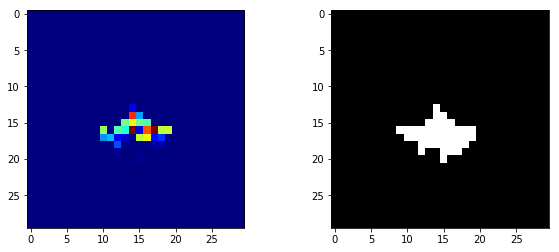

In [40]:
plt.figure( figsize=(10, 4))
ax = plt.subplot(121)
ax.imshow(hm, cmap=plt.cm.jet)
ax = plt.subplot(122)
ax.imshow(som.mask, cmap=plt.cm.gray)
plt.show()